# Pytorch
## Tensor
1. scalar: 0维，数字
2. vector: 1维
3. matrix: 2维
4. tensor: 3维或更多

为了简便起见，我们把vector和matrix也叫做tensor.  
tensor()既能创建scalar也能创建tensor. Pytorch里的tensor和numpy很像。

In [1]:
import torch
scalar = torch.tensor(3.14159)
vector = torch.tensor([1,2,3])
matrix = torch.ones((2,3), dtype=torch.float)
tensor = torch.randn((2,3,4), dtype=torch.float)
print(tensor)
print(tensor.size(), tensor.shape)
print(vector.size(), vector.shape)
print(scalar.size(), scalar.shape)

tensor([[[-1.5623,  1.2617, -0.7663, -0.4424],
         [ 1.5027,  0.2160,  0.2078,  0.4431],
         [ 1.1256, -0.0226,  1.0234, -1.1170]],

        [[-1.4024,  0.5176,  0.5074,  0.5848],
         [-1.1117,  0.4459,  0.6979,  0.9647],
         [-0.1269,  0.0614, -1.0792,  0.4969]]])
torch.Size([2, 3, 4]) torch.Size([2, 3, 4])
torch.Size([3]) torch.Size([3])
torch.Size([]) torch.Size([])


In [16]:
same_matrix = matrix.view(1,6)
print(same_matrix)
same_matrix[0,1]=2
print(same_matrix)
another_matrix = same_matrix.clone().detach() # duplicate the data
print(another_matrix)

tensor([[1., 1., 1., 1., 1., 1.]])
tensor([[1., 2., 1., 1., 1., 1.]])
tensor([[1., 2., 1., 1., 1., 1.]])


## CUDA
我们可以用torch.as_tensor()很方便地把numpy数组转成tensor.

In [3]:
import numpy as np
dummy_array = np.array([1,2,3])
dummy_tensor = torch.as_tensor(dummy_array)
dummy_array[1]=0
dummy_tensor
# 注意这里是改引用而不是改拷贝。这也是我们不用torch.tensor()的原因

tensor([1, 0, 3])

以上我们只是创建了CPU tensor，接下来我们使用GPU.显然GPU可以加速模型训练。  

In [18]:
# 查看GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.cuda.get_device_name(0))

# 把cpu tensor转成gpu tensor
gpu_tensor = torch.as_tensor(dummy_array).to(device)
gpu_tensor[0]

cuda
NVIDIA GeForce GTX 1060 6GB


tensor(1, device='cuda:0')

In [4]:
# Synthetic Data Generation
true_b = 1
true_w = 2
N = 100
np.random.seed(42)

x = np.random.rand(N,1)
epsilon = .1 * np.random.randn(N,1)
y = true_b + true_w * x + epsilon

# Split the synthetic data into train and validation sets.
idx = np.arange(N)
np.random.shuffle(idx)
train_idx = idx[:int(N*.8)]
val_idx = idx[int(N*.8):]
x_train,y_train = x[train_idx],y[train_idx]
x_val,y_val = x[val_idx,],y[val_idx]

In [20]:
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())
# 用tensor_val.type()可以告诉你这是GPU tensor

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.cuda.FloatTensor


In [21]:
# step0 - initialize parameters
# 变量在创建时就指定好device
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(b,w)

tensor([0.1940], device='cuda:0', requires_grad=True) tensor([0.1391], device='cuda:0', requires_grad=True)


## Autograd

In [22]:
# step1 - compute predictions, forward pass
yhat = b + w * x_train_tensor 

# step2 - compute loss
error = yhat - y_train_tensor
loss = (error ** 2).mean()

# step3 - compute gradients, no more manual computation
loss.backward()

In [23]:
print(error.requires_grad, yhat.requires_grad, b.requires_grad, w.requires_grad)
print(y_train_tensor.requires_grad, x_train_tensor.requires_grad)
print(b.grad, w.grad)
# 如果再次运行step1~3,梯度会被累积(差不多是x2),这是为了规避硬件限制，但这不是我们想要的。
b.grad.zero_(), w.grad.zero_() # 放在step4之后，把gradients afterward置0
# torch.no_grad() 可以让我们在不影响computation graph下执行python运算.


True True True True
False False
tensor([-3.3881], device='cuda:0') tensor([-1.9439], device='cuda:0')


(tensor([0.], device='cuda:0'), tensor([0.], device='cuda:0'))

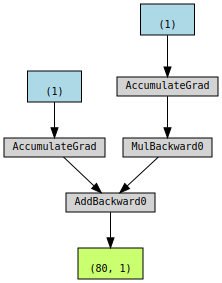

In [24]:
from torchviz import make_dot
# step0
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
# step1
yhat = b + w * x_train_tensor
# step2
error = yhat - y_train_tensor
loss = (error ** 2).mean()
# plotting the graph
make_dot(yhat)


## 计算图
蓝框是我们所使用的tensor参数(左b右w)，灰框(MulBackward0 AddBackward0)是梯度计算($w*x, b+w*x$)，绿框backward()所需的tensor.
## Optimizer
两个参数我们可以手动更新，但有大量的参数时呢？就需要optimizer,SGD是最基本的optimizer.
```python
optimizer = torch.optim.SGD([b,w], lr=lr)
```

In [27]:
lr = 0.1
# step0 - initialize parameters b and w
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
# define a SGD optimizer to update parameters
optimizer = torch.optim.SGD([b,w], lr=lr)

n_epochs = 1000
for epoch in range(n_epochs):
    # step1 - computes predictions
    yhat = b + w * x_train_tensor
    # step2 - computes loss
    error = yhat - y_train_tensor
    loss = (error ** 2).mean()
    # step3 - computes gradients
    loss.backward()
    # step4 - updates parameters
    optimizer.step()
    # no more b-=lr*b.grad and w-=lr*w.grad
    optimizer.zero_grad()
    # no more b.grad.zero_() and w.grad.zero_()

print(b,w)


tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


## Loss
```python
loss_fn = torch.nn.MSELoss(reduction='mean')
```

In [29]:
lr = 0.1
# step0 - initialize parameters b and w
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
# define a SGD optimizer to update parameters
optimizer = torch.optim.SGD([b,w], lr=lr)
# define MSE loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

n_epochs = 1000
for epoch in range(n_epochs):
    # step1 - computes predictions
    yhat = b + w * x_train_tensor
    # step2 - computes loss
    loss = loss_fn(yhat, y_train_tensor)
    # step3 - computes gradients
    loss.backward()
    # step4 - updates parameters
    optimizer.step()
    # no more b-=lr*b.grad and w-=lr*w.grad
    optimizer.zero_grad()
    # no more b.grad.zero_() and w.grad.zero_()

print(b,w)

tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


## Model

In [33]:
class ManualLinearRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.b = torch.nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))
        self.w = torch.nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))

    def forward(self, x):
        return self.b + self.w * x

dummy = ManualLinearRegression()
list(dummy.parameters())
dummy.state_dict()
optimizer.state_dict()

{'state': {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.1,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0, 1]}]}

In [34]:
lr = 0.1
# step0 - initialize parameters
torch.manual_seed(42)
model = ManualLinearRegression().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss(reduction='mean')

n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    # step1 computes predictions
    yhat = model(x_train_tensor)
    # step2 - computes loss
    loss = loss_fn(yhat, y_train_tensor)
    # step3 - computes gradients
    loss.backward()
    # step4 - updates parameters
    optimizer.step()
    optimizer.zero_grad()

print(model.state_dict())

OrderedDict([('b', tensor([1.0235], device='cuda:0')), ('w', tensor([1.9690], device='cuda:0'))])


In [37]:
linear = torch.nn.Linear(1,1)
linear
linear.state_dict()

model = torch.nn.Sequential()
model.add_module('layer1', torch.nn.Linear(3,5))
model.add_module('layer2', torch.nn.Linear(5,1))
model.to(device)

Sequential(
  (layer1): Linear(in_features=3, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

## Summary

In [6]:
%%writefile data_preparation/v0.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

Writing data_preparation/v0.py


In [ ]:
%%writefile model_configuration/v0.py

lr = 0.1
torch.manual_seed(42)
model = n